In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy.io import fits
from astronet.preprocess import generate_input_records
from astronet.preprocess import preprocess
from light_curve_util import keplersplinev2
from light_curve_util import tess_io
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


tce_tables = {}

tce_files = [
    '/mnt/tess/astronet/tces-toi.csv',
#     '/mnt/tess/astronet/tces-toi-bls-vs-tev.csv',
    '/mnt/tess/astronet/tces-s33_cam1_sample.csv',
    '/mnt/tess/astronet/tces-s33_cam2ccd14_sample.csv',
    '/mnt/tess/astronet/tces-v6-train.csv',
    '/mnt/tess/astronet/tces-v6-val.csv',
    '/mnt/tess/astronet/tces-v6-test.csv',
]


def get_tce(tic, item_no):
    for f in tce_files:
        if f not in tce_tables:
            tce_tables[f] = pd.read_csv(f, header=0)
        tce_table = tce_tables[f]
        tce = tce_table[tce_table.tic_id == tic]
        if not len(tce):
            continue
        if len(tce) > 1:
            tce = tce[tce.index == tce.index.values[item_no]]
            if 'Source' in tce:
                print('Source:', 'BLS' if tce.Source.values.item() == 2 else 'TEV')
        return tce, f
    raise ValueError(f'no TCE data for {tic}')

Epoc: 2202.337571
Period: 3.288877
Duration: 0.14192933333333332
multiple matches, selected ['/mnt/tess/lc/tess2021070000000-s0013-0000000025155310-1111-cr_llc.fits.gz']


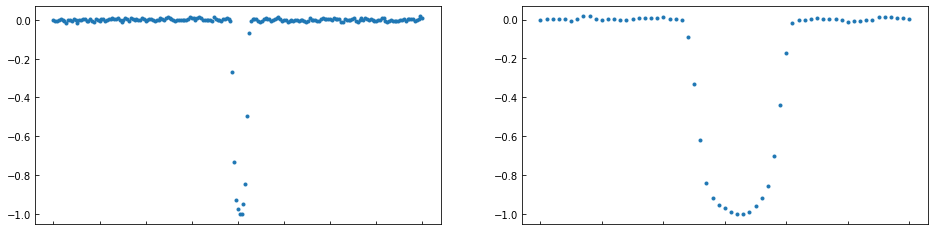

In [11]:
def plot_all(tic,
             large=False,
             dpi=100,
             bkspace=None,
             abs_xlim=None,
             abs_offset=0,
             abs_ylim=None,
             rpt_only=False,
             item_no=0):
    tess_data_dir = f'/mnt/tess/lc'
    reports_dir = f'/mnt/tess/rpt/png'

    tce, tces_file = get_tce(tic, item_no)
    period = tce.Period.values.item()
    epoc = tce.Epoc.values.item()
    duration = tce.Duration.values.item()

    print(f'Epoc: {epoc}\nPeriod: {period}\nDuration: {duration}')
    
    generate_input_records.FLAGS = generate_input_records.parser.parse_args([
      '--tess_data_dir', '/mnt/tess/lc',
      '--output_dir', '/dev/null',
      '--input_tce_csv_file', tces_file,
    ])


    row = list(tce.iterrows())[0][1]

    ex = generate_input_records._process_tce(row, bkspace)
    return ex

def plot_normal(ex):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(121)
    ax.set_xticklabels([])
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.plot(ex.features.feature['global_view'].float_list.value, linestyle='', marker='.')
    ax = fig.add_subplot(122)
    ax.set_xticklabels([])
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.plot(ex.features.feature['local_view'].float_list.value, linestyle='', marker='.')
    

ex = plot_all(25155310)
plot_normal(ex)

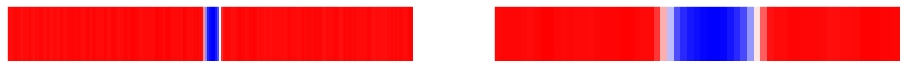

In [14]:
def plot_img(ex):
    fig = plt.figure(figsize=(16, 1))
    ax = fig.add_subplot(121)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    plt.imshow(
        np.array(ex.features.feature['global_view'].float_list.value).reshape(1, 201),
        cmap=plt.get_cmap('bwr'),
        aspect='auto',
        interpolation='none',
    )
    ax = fig.add_subplot(122)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    plt.imshow(
        np.array(ex.features.feature['local_view'].float_list.value).reshape(1, 61),
        cmap=plt.get_cmap('bwr'),
        aspect='auto',
        interpolation='none',
    )
    
plot_img(ex)

In [ ]:
def plot_all(tic,
             large=False,
             dpi=100,
             bkspace=None,
             abs_xlim=None,
             abs_offset=0,
             abs_ylim=None,
             rpt_only=False,
             item_no=0):
    tess_data_dir = f'/mnt/tess/lc'
    reports_dir = f'/mnt/tess/rpt/png'

    if rpt_only:
        plt.figure(figsize=(12, 8), dpi=dpi)
        plt.axis('off')
        im = plt.imread(f'{reports_dir}/TIC{tic}.png')
        _ = plt.imshow(im)
        plt.show()
        print(get_tce(tic, item_no)[0])
        return
        
    b = plt.get_cmap('tab20')(0)
    b2 = plt.get_cmap('tab20')(1)
    o = plt.get_cmap('tab20')(2)
    o2 = plt.get_cmap('tab20')(3)
    g = plt.get_cmap('tab20')(4)
    r = plt.get_cmap('tab20')(6)
    n = plt.get_cmap('tab20')(8)
    k = plt.get_cmap('tab20')(14)

    plotrows = 1
    plotcols = 3
    
    if large:
        fsize = (16, 9)
    else:
        fsize = (16, 4 * (plotrows + 1))
        plt.figure(figsize=fsize, dpi=dpi)
    
    tce, tces_file = get_tce(tic, item_no)
    period = tce.Period.values.item()
    epoc = tce.Epoc.values.item()
    duration = tce.Duration.values.item()

    print(f'Epoc: {epoc}\nPeriod: {period}\nDuration: {duration}')
    
    def config_abs_plot(title):
        plt.legend()
        plt.title(title)
        if abs_xlim:
            if abs_xlim == '3p':
                minx = min(td) + abs_offset * period
                maxx = minx + 3.5 * period
                plt.xlim(minx, maxx)
            else:
                plt.xlim(*abs_xlim)
        if abs_ylim:
            if abs_ylim == '3%':
                miny = np.percentile(fs[~np.isnan(fs)], 3)
                maxy = np.percentile(fs[~np.isnan(fs)], 97)
                plt.ylim(miny, maxy)
            else:
                plt.ylim(*abs_ylim)
                
    nplotted = 0
    def splt(c=1):
        nonlocal nplotted
        if large:
            plt.figure(figsize=fsize, dpi=dpi)
        else:
            plt.subplot(plotrows, plotcols // c, (nplotted // c) + 1)
        nplotted += c
    
    
    file_names = tess_io.tess_filenames(tic, tess_data_dir)
    f = fits.open(file_names)

    td = f[1].data["TIME"]
    fd = f[1].data["KSPSAP_FLUX"]
    fs = f[1].data["SAP_FLUX"]
    
#     splt()
#     plt.plot(td, fs, '-', alpha=0.6, color=g, label='SAP')
#     config_abs_plot('fits data')
    
    
    ut, uf = preprocess.read_and_process_light_curve(tic, tess_data_dir, 'SAP_FLUX')

    input_mask = preprocess.get_spline_mask(ut, period, epoc, duration)
    sf, mdata = keplersplinev2.choosekeplersplinev2(
        ut, uf, input_mask=input_mask, return_metadata=True,
        fixed_bkspace=bkspace,
    )

    splt()
    plt.plot(ut, uf, '-', alpha=0.6, color=g, label='SAP')
    plt.plot(ut[input_mask], sf[input_mask], 'x', markersize=3, color=k, label='spline (out of transit)')
    plt.plot(ut[~input_mask], sf[~input_mask], 'o', markersize=3, color=o, label='spline (transit)')
    config_abs_plot(f'raw | bkspace: {mdata.bkspace}')
    
    
    ut, nf, fm = preprocess.detrend_and_filter(
        tic, ut, uf, period, epoc, duration, bkspace)
    sft, sff, sfn, sftm = preprocess.phase_fold_and_sort_light_curve(
        ut, nf, input_mask, period, epoc)

#     splt()
#     plt.plot(sft, sff, 'o', markersize=3, alpha=0.6, c=o, label='spline')
#     sff_filtered = np.where((sff > 1.5) | (sff < -0.5), 0, sff)
#     if len(sff_filtered):
#         mask = np.where(sftm, 1, min(sff_filtered))
#         plt.plot(sft, mask, '-', markersize=1, alpha=0.6, c=r, label='OOT')
#         title = f'phase folded ({int(max(sfn) + 1)} folds) / filtered'
#     else:
#         if len(sfn):
#             title = f'phase folded ({int(max(sfn) + 1)} folds) | WARNING: filtering removed all data'
#         else:
#             title = f'phase folded | WARNING: filtering removed all data'
#     plt.legend(prop={'size': 14})
#     plt.title(title)


    generate_input_records.FLAGS = generate_input_records.parser.parse_args([
      '--tess_data_dir', '/mnt/tess/lc',
      '--output_dir', '/dev/null',
      '--input_tce_csv_file', tces_file,
    ])


    row = list(tce.iterrows())[0][1]

    ex = generate_input_records._process_tce(row, bkspace)
    
    
    def plot_w_scatter(view, std, title, mask=None):
        splt()
        view = np.array(ex.features.feature[view].float_list.value)
        std = np.array(ex.features.feature[std].float_list.value)
        plt.plot(std, color=o, label='Standard deviation')
        plt.plot(view, color=n, label='Filtered mean')
        if mask:
            plt.plot(
                -np.array(ex.features.feature[mask].float_list.value), color=r, alpha=0.5, linestyle='--',
            label='Transit mask')
        plt.legend(prop={'size': 14})
        plt.title(title)
        
    def plot_norm(view, title):
        splt()
        plt.plot(ex.features.feature[view].float_list.value, color=n)
        plt.ylim(-1, 1)
        plt.title(title)    
        
        
    def plot_segments(view, tag):
        splt(c=3)
        img = ex.features.feature[view].float_list.value
        img = np.reshape(img, (-1, 14))
        n_transits = img.shape[1] // 2
        for i in range(n_transits):
            view = img[:, 2 * i]
            mask = img[:, 2 * i + 1] > 0
            plt.plot(np.where(mask, view, np.nan), marker='.', label=f'Sample transit {i}')
        plt.legend(prop={'size': 14})
        plt.title(f'{n_transits} sample segments, densest first, ties broken at random {tag}')
        
#     plot_w_scatter('global_view', 'global_std', 'global')
#     plot_w_scatter('global_view_0.3', 'global_std_0.3', 'global @ 0.3')
#     plot_w_scatter('global_view_5.0', 'global_std_5.0', 'global @ 5.0')

    sec_phase = ex.features.feature['secondary_phase'].float_list.value[0]
    loc_scale = ex.features.feature['local_scale'].float_list.value[0]
    sec_scale = ex.features.feature['secondary_scale'].float_list.value[0]
#     plot_w_scatter('global_view', 'global_std', 'global', 'global_transit_mask')
#     plot_w_scatter('local_view', 'local_std', f'local / {loc_scale:0.3}')
#     plot_w_scatter('secondary_view', 'secondary_std', f'secondary ({sec_phase:0.2}) / {sec_scale:0.5}')
#     plot_norm('global_view_half_period', 'global half period')
#     plot_norm('global_view_double_period', 'global double period (shifted)')
#     splt()
#     plot_segments('sample_segments_view', '')

#     sec_phase = ex.features.feature['secondary_phase_0.3'].float_list.value[0]
#     loc_scale = ex.features.feature['local_scale_0.3'].float_list.value[0]
#     sec_scale = ex.features.feature['secondary_scale_0.3'].float_list.value[0]
#     plot_w_scatter('global_view_0.3', 'global_std_0.3', 'global @ 0.3', 'global_transit_mask_0.3')
#     plot_w_scatter('local_view_0.3', 'local_std_0.3', f'local @ 0.3 / {loc_scale:0.3}')
#     plot_w_scatter('secondary_view_0.3', 'secondary_std_0.3', f'secondary @ 0.3 ({sec_phase:0.2}) / {sec_scale:0.5}')
#     plot_norm('global_view_half_period_0.3', 'global half period @ 0.3')
#     plot_norm('global_view_double_period_0.3', 'global double period (shifted) @ 0.3')
#     splt()
#     plot_segments('sample_segments_view_0.3', ' @ 0.3')

#     sec_phase = ex.features.feature['secondary_phase_5.0'].float_list.value[0]
#     loc_scale = ex.features.feature['local_scale_5.0'].float_list.value[0]
#     sec_scale = ex.features.feature['secondary_scale_5.0'].float_list.value[0]
#     plot_w_scatter('global_view_5.0', 'global_std_5.0', 'global @ 5.0', 'global_transit_mask_5.0')
#     plot_w_scatter('local_view_5.0', 'local_std_5.0', f'local @ 5.0 / {loc_scale:0.3}')
#     plot_w_scatter('secondary_view_5.0', 'secondary_std_5.0', f'secondary @ 5.0 ({sec_phase:0.2}) / {sec_scale:0.5}')
#     plot_norm('global_view_half_period_5.0', 'global half period @ 5.0')
#     plot_norm('global_view_double_period_5.0', 'global double period (shifted) @ 5.0')
#     splt()
#     plot_segments('sample_segments_view_5.0', ' @ 5.0')
    
#     try:
#         im = plt.imread(f'{reports_dir}/TIC{tic}.png')
#         plt.figure(figsize=(12, 8), dpi=dpi)
#         plt.axis('off')
#         _ = plt.imshow(im)
#     except FileNotFoundError:
#         print('-- no report file --')

plot_all(354444731, large=True)


In [ ]:
def plot_all(tic,
             large=False,
             dpi=100,
             bkspace=None,
             abs_xlim=None,
             abs_offset=0,
             abs_ylim=None,
             rpt_only=False,
             item_no=0):
    tess_data_dir = f'/mnt/tess/lc'
    reports_dir = f'/mnt/tess/rpt/png'

    if rpt_only:
        plt.figure(figsize=(12, 8), dpi=dpi)
        plt.axis('off')
        im = plt.imread(f'{reports_dir}/TIC{tic}.png')
        _ = plt.imshow(im)
        plt.show()
        print(get_tce(tic, item_no)[0])
        return
        
    b = plt.get_cmap('tab20')(0)
    b2 = plt.get_cmap('tab20')(1)
    o = plt.get_cmap('tab20')(2)
    o2 = plt.get_cmap('tab20')(3)
    g = plt.get_cmap('tab20')(4)
    r = plt.get_cmap('tab20')(6)
    n = plt.get_cmap('tab20')(8)
    k = plt.get_cmap('tab20')(14)

    plotrows = 1
    plotcols = 3
    
    if large:
        fsize = (5, 3)
    else:
        fsize = (16, 4 * (plotrows + 1))
        plt.figure(figsize=fsize, dpi=dpi)
    
    tce, tces_file = get_tce(tic, item_no)
    period = tce.Period.values.item()
    epoc = tce.Epoc.values.item()
    duration = tce.Duration.values.item()

    print(f'Epoc: {epoc}\nPeriod: {period}\nDuration: {duration}')
    
    def config_abs_plot(title):
#         plt.legend()
        plt.title(title)
        if abs_xlim:
            if abs_xlim == '3p':
                minx = min(td) + abs_offset * period
                maxx = minx + 3.5 * period
                plt.xlim(minx, maxx)
            else:
                plt.xlim(*abs_xlim)
        if abs_ylim:
            if abs_ylim == '3%':
                miny = np.percentile(fs[~np.isnan(fs)], 3)
                maxy = np.percentile(fs[~np.isnan(fs)], 97)
                plt.ylim(miny, maxy)
            else:
                plt.ylim(*abs_ylim)
                
    nplotted = 0
    def splt(c=1):
        nonlocal nplotted
        if large:
            plt.figure(figsize=fsize, dpi=dpi)
        else:
            plt.subplot(plotrows, plotcols // c, (nplotted // c) + 1)
        nplotted += c
    
    
    file_names = tess_io.tess_filenames(tic, tess_data_dir)
    f = fits.open(file_names)

    td = f[1].data["TIME"]
    fd = f[1].data["KSPSAP_FLUX"]
    fs = f[1].data["SAP_FLUX"]
    
#     splt()
#     plt.plot(td, fs, '-', alpha=0.6, color=g, label='SAP')
#     config_abs_plot('fits data')
    
    
    ut, uf = preprocess.read_and_process_light_curve(tic, tess_data_dir, 'SAP_FLUX')

    input_mask = preprocess.get_spline_mask(ut, period, epoc, duration)
    sf, mdata = keplersplinev2.choosekeplersplinev2(
        ut, uf, input_mask=input_mask, return_metadata=True,
        fixed_bkspace=bkspace,
    )

    splt()
    plt.plot(ut, uf, '-', alpha=0.6, color=g, label='SAP')
    plt.plot(ut[input_mask], sf[input_mask], 'x', markersize=3, color=k, label='spline (out of transit)')
    plt.plot(ut[~input_mask], sf[~input_mask], 'o', markersize=3, color=o, label='spline (transit)')
    config_abs_plot(f'raw | bkspace: {mdata.bkspace}')
    
    
    ut, nf, fm = preprocess.detrend_and_filter(
        tic, ut, uf, period, epoc, duration, bkspace)
    sft, sff, sfn, sftm = preprocess.phase_fold_and_sort_light_curve(
        ut, nf, input_mask, period, epoc)

#     splt()
#     plt.plot(sft, sff, 'o', markersize=3, alpha=0.6, c=o, label='spline')
#     sff_filtered = np.where((sff > 1.5) | (sff < -0.5), 0, sff)
#     if len(sff_filtered):
#         mask = np.where(sftm, 1, min(sff_filtered))
#         plt.plot(sft, mask, '-', markersize=1, alpha=0.6, c=r, label='OOT')
#         title = f'phase folded ({int(max(sfn) + 1)} folds) / filtered'
#     else:
#         if len(sfn):
#             title = f'phase folded ({int(max(sfn) + 1)} folds) | WARNING: filtering removed all data'
#         else:
#             title = f'phase folded | WARNING: filtering removed all data'
#     plt.legend(prop={'size': 14})
#     plt.title(title)


    generate_input_records.FLAGS = generate_input_records.parser.parse_args([
      '--tess_data_dir', '/mnt/tess/lc',
      '--output_dir', '/dev/null',
      '--input_tce_csv_file', tces_file,
    ])


    row = list(tce.iterrows())[0][1]

    ex = generate_input_records._process_tce(row, bkspace)
    
    
    def plot_w_scatter(view, std, title, mask=None):
        splt()
        view = np.array(ex.features.feature[view].float_list.value)
        std = np.array(ex.features.feature[std].float_list.value)
        plt.plot(std, color=o, label='Standard deviation')
        plt.plot(view, color=n, label='Filtered mean')
        if mask:
            plt.plot(
                -np.array(ex.features.feature[mask].float_list.value), color=r, alpha=0.5, linestyle='--',
            label='Transit mask')
#         plt.legend(prop={'size': 14})
        plt.title(title)
        
    def plot_norm(view, title):
        splt()
        plt.plot(ex.features.feature[view].float_list.value, color=n)
        plt.ylim(-1, 1)
        plt.title(title)    
        
        
    def plot_segments(view, tag):
        splt(c=3)
        img = ex.features.feature[view].float_list.value
        img = np.reshape(img, (-1, 14))
        n_transits = img.shape[1] // 2
        for i in range(n_transits):
            view = img[:, 2 * i]
            mask = img[:, 2 * i + 1] > 0
            plt.plot(np.where(mask, view, np.nan), marker='.', label=f'Sample transit {i}')
        plt.legend(prop={'size': 14})
        plt.title(f'{n_transits} sample segments, densest first, ties broken at random {tag}')
        
#     plot_w_scatter('global_view', 'global_std', 'global')
#     plot_w_scatter('global_view_0.3', 'global_std_0.3', 'global @ 0.3')
#     plot_w_scatter('global_view_5.0', 'global_std_5.0', 'global @ 5.0')

    sec_phase = ex.features.feature['secondary_phase'].float_list.value[0]
    loc_scale = ex.features.feature['local_scale'].float_list.value[0]
    sec_scale = ex.features.feature['secondary_scale'].float_list.value[0]
#     plot_w_scatter('global_view', 'global_std', 'global', 'global_transit_mask')
#     plot_w_scatter('local_view', 'local_std', f'local / {loc_scale:0.3}')
#     plot_w_scatter('secondary_view', 'secondary_std', f'secondary ({sec_phase:0.2}) / {sec_scale:0.5}')
#     plot_norm('global_view_half_period', 'global half period')
#     plot_norm('global_view_double_period', 'global double period (shifted)')
#     splt()
#     plot_segments('sample_segments_view', '')

#     sec_phase = ex.features.feature['secondary_phase_0.3'].float_list.value[0]
#     loc_scale = ex.features.feature['local_scale_0.3'].float_list.value[0]
#     sec_scale = ex.features.feature['secondary_scale_0.3'].float_list.value[0]
    plot_w_scatter('global_view_0.3', 'global_std_0.3', 'global @ 0.3', 'global_transit_mask_0.3')
#     plot_w_scatter('local_view_0.3', 'local_std_0.3', f'local @ 0.3 / {loc_scale:0.3}')
#     plot_w_scatter('secondary_view_0.3', 'secondary_std_0.3', f'secondary @ 0.3 ({sec_phase:0.2}) / {sec_scale:0.5}')
#     plot_norm('global_view_half_period_0.3', 'global half period @ 0.3')
#     plot_norm('global_view_double_period_0.3', 'global double period (shifted) @ 0.3')
#     splt()
#     plot_segments('sample_segments_view_0.3', ' @ 0.3')

#     sec_phase = ex.features.feature['secondary_phase_5.0'].float_list.value[0]
#     loc_scale = ex.features.feature['local_scale_5.0'].float_list.value[0]
#     sec_scale = ex.features.feature['secondary_scale_5.0'].float_list.value[0]
#     plot_w_scatter('global_view_5.0', 'global_std_5.0', 'global @ 5.0', 'global_transit_mask_5.0')
#     plot_w_scatter('local_view_5.0', 'local_std_5.0', f'local @ 5.0 / {loc_scale:0.3}')
#     plot_w_scatter('secondary_view_5.0', 'secondary_std_5.0', f'secondary @ 5.0 ({sec_phase:0.2}) / {sec_scale:0.5}')
#     plot_norm('global_view_half_period_5.0', 'global half period @ 5.0')
#     plot_norm('global_view_double_period_5.0', 'global double period (shifted) @ 5.0')
#     splt()
#     plot_segments('sample_segments_view_5.0', ' @ 5.0')
    
#     try:
#         im = plt.imread(f'{reports_dir}/TIC{tic}.png')
#         plt.figure(figsize=(12, 8), dpi=dpi)
#         plt.axis('off')
#         _ = plt.imshow(im)
#     except FileNotFoundError:
#         print('-- no report file --')

plot_all(354444731, large=True, bkspace=0.3)

In [ ]:
from astropy.io import fits
from astronet.preprocess import generate_input_records
from astronet.preprocess import preprocess
from light_curve_util import keplersplinev2
from light_curve_util import tess_io
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


tce_tables = {}

tce_files = [
    '/mnt/tess/astronet/tces-toi.csv',
#     '/mnt/tess/astronet/tces-toi-bls-vs-tev.csv',
    '/mnt/tess/astronet/tces-s33_cam1_sample.csv',
    '/mnt/tess/astronet/tces-s33_cam2ccd14_sample.csv',
    '/mnt/tess/astronet/tces-v6-train.csv',
    '/mnt/tess/astronet/tces-v6-val.csv',
    '/mnt/tess/astronet/tces-v6-test.csv',
]


def get_tce(tic, item_no):
    for f in tce_files:
        if f not in tce_tables:
            tce_tables[f] = pd.read_csv(f, header=0)
        tce_table = tce_tables[f]
        tce = tce_table[tce_table.tic_id == tic]
        if not len(tce):
            continue
        if len(tce) > 1:
            tce = tce[tce.index == tce.index.values[item_no]]
            if 'Source' in tce:
                print('Source:', 'BLS' if tce.Source.values.item() == 2 else 'TEV')
        return tce, f
    raise ValueError(f'no TCE data for {tic}')


def plot_all(tic,
             large=False,
             dpi=100,
             bkspace=None,
             abs_xlim=None,
             abs_offset=0,
             abs_ylim=None,
             rpt_only=False,
             item_no=0):
    tess_data_dir = f'/mnt/tess/lc'
    reports_dir = f'/mnt/tess/rpt/png'

    if rpt_only:
        plt.figure(figsize=(12, 8), dpi=dpi)
        plt.axis('off')
        im = plt.imread(f'{reports_dir}/TIC{tic}.png')
        _ = plt.imshow(im)
        plt.show()
        print(get_tce(tic, item_no)[0])
        return
        
    b = plt.get_cmap('tab20')(0)
    b2 = plt.get_cmap('tab20')(1)
    o = plt.get_cmap('tab20')(2)
    o2 = plt.get_cmap('tab20')(3)
    g = plt.get_cmap('tab20')(4)
    r = plt.get_cmap('tab20')(6)
    n = plt.get_cmap('tab20')(8)
    k = plt.get_cmap('tab20')(14)

    plotrows = 11
    plotcols = 3
    
    if large:
        fsize = (16, 9)
    else:
        fsize = (16, 3 * (plotrows + 1))
        plt.figure(figsize=fsize, dpi=dpi)
    
    tce, tces_file = get_tce(tic, item_no)
    period = tce.Period.values.item()
    epoc = tce.Epoc.values.item()
    duration = tce.Duration.values.item()

    print(f'Epoc: {epoc}\nPeriod: {period}\nDuration: {duration}')
    
    def config_abs_plot(title):
        plt.legend()
        plt.title(title)
        if abs_xlim:
            if abs_xlim == '3p':
                minx = min(td) + abs_offset * period
                maxx = minx + 3.5 * period
                plt.xlim(minx, maxx)
            else:
                plt.xlim(*abs_xlim)
        if abs_ylim:
            if abs_ylim == '3%':
                miny = np.percentile(fs[~np.isnan(fs)], 3)
                maxy = np.percentile(fs[~np.isnan(fs)], 97)
                plt.ylim(miny, maxy)
            else:
                plt.ylim(*abs_ylim)
                
    nplotted = 0
    def splt(c=1):
        nonlocal nplotted
        if large:
            plt.figure(figsize=fsize, dpi=dpi)
        else:
            plt.subplot(plotrows, plotcols // c, (nplotted // c) + 1)
        nplotted += c
    
    
    file_names = tess_io.tess_filenames(tic, tess_data_dir)
    f = fits.open(file_names)

    td = f[1].data["TIME"]
    fd = f[1].data["KSPSAP_FLUX"]
    fs = f[1].data["SAP_FLUX"]
    
#     splt()
#     plt.plot(td, fs, '-', alpha=0.6, color=g, label='SAP')
#     config_abs_plot('fits data')
    
    
    splt()
    ut, uf = preprocess.read_and_process_light_curve(tic, tess_data_dir, 'SAP_FLUX')

    input_mask = preprocess.get_spline_mask(ut, period, epoc, duration)
    sf, mdata = keplersplinev2.choosekeplersplinev2(
        ut, uf, input_mask=input_mask, return_metadata=True,
        fixed_bkspace=bkspace,
    )

    plt.plot(ut, uf, '-', alpha=0.6, color=g, label='SAP')
    plt.plot(ut[input_mask], sf[input_mask], 'x', markersize=3, color=k, label='spline (OOT)')
    plt.plot(ut[~input_mask], sf[~input_mask], 'o', markersize=3, color=o, label='spline')
    config_abs_plot(f'raw | bkspace: {mdata.bkspace}')
    
    
    ut, nf, fm = preprocess.detrend_and_filter(
        tic, ut, uf, period, epoc, duration, bkspace)
    sft, sff, sfn, sftm = preprocess.phase_fold_and_sort_light_curve(
        ut, nf, input_mask, period, epoc)

    splt()
    plt.plot(sft, sff, 'o', markersize=3, alpha=0.6, c=o, label='spline')
    sff_filtered = np.where((sff > 1.5) | (sff < -0.5), 0, sff)
    if len(sff_filtered):
        mask = np.where(sftm, 1, min(sff_filtered))
        plt.plot(sft, mask, '-', markersize=1, alpha=0.6, c=r, label='OOT')
        title = f'phase folded ({int(max(sfn) + 1)} folds) / filtered'
    else:
        if len(sfn):
            title = f'phase folded ({int(max(sfn) + 1)} folds) | WARNING: filtering removed all data'
        else:
            title = f'phase folded | WARNING: filtering removed all data'
    plt.legend()
    plt.title(title)


    generate_input_records.FLAGS = generate_input_records.parser.parse_args([
      '--tess_data_dir', '/mnt/tess/lc',
      '--output_dir', '/dev/null',
      '--input_tce_csv_file', tces_file,
    ])


    row = list(tce.iterrows())[0][1]

    ex = generate_input_records._process_tce(row, bkspace)
    
    
    def plot_w_scatter(view, std, title, mask=None):
        splt()
        view = np.array(ex.features.feature[view].float_list.value)
        std = np.array(ex.features.feature[std].float_list.value)
        plt.plot(std, color=o)
        plt.plot(view, color=n)
        if mask:
            plt.plot(
                -np.array(ex.features.feature[mask].float_list.value), color=r, alpha=0.5, linestyle='--')
        plt.title(title)
        
    def plot_norm(view, title):
        splt()
        plt.plot(ex.features.feature[view].float_list.value, color=n)
        plt.ylim(-1, 1)
        plt.title(title)    
        
        
    def plot_segments(view, tag):
        splt(c=3)
        img = ex.features.feature[view].float_list.value
        img = np.reshape(img, (-1, 14))
        n_transits = img.shape[1] // 2
        for i in range(n_transits):
            view = img[:, 2 * i]
            mask = img[:, 2 * i + 1] > 0
            plt.plot(np.where(mask, view, np.nan), marker='.')
        plt.title(f'{n_transits} sample segments, densest first, ties broken at random {tag}')
        
#     plot_w_scatter('global_view', 'global_std', 'global')
#     plot_w_scatter('global_view_0.3', 'global_std_0.3', 'global @ 0.3')
#     plot_w_scatter('global_view_5.0', 'global_std_5.0', 'global @ 5.0')

    sec_phase = ex.features.feature['secondary_phase'].float_list.value[0]
    loc_scale = ex.features.feature['local_scale'].float_list.value[0]
    sec_scale = ex.features.feature['secondary_scale'].float_list.value[0]
    plot_w_scatter('global_view', 'global_std', 'global', 'global_transit_mask')
    plot_w_scatter('local_view', 'local_std', f'local / {loc_scale:0.3}')
    plot_w_scatter('secondary_view', 'secondary_std', f'secondary ({sec_phase:0.2}) / {sec_scale:0.5}')
#     plot_norm('global_view_half_period', 'global half period')
    plot_norm('global_view_double_period', 'global double period (shifted)')
    splt()
    plot_segments('sample_segments_view', '')

#     sec_phase = ex.features.feature['secondary_phase_0.3'].float_list.value[0]
#     loc_scale = ex.features.feature['local_scale_0.3'].float_list.value[0]
#     sec_scale = ex.features.feature['secondary_scale_0.3'].float_list.value[0]
#     plot_w_scatter('global_view_0.3', 'global_std_0.3', 'global @ 0.3', 'global_transit_mask_0.3')
#     plot_w_scatter('local_view_0.3', 'local_std_0.3', f'local @ 0.3 / {loc_scale:0.3}')
#     plot_w_scatter('secondary_view_0.3', 'secondary_std_0.3', f'secondary @ 0.3 ({sec_phase:0.2}) / {sec_scale:0.5}')
#     plot_norm('global_view_half_period_0.3', 'global half period @ 0.3')
#     plot_norm('global_view_double_period_0.3', 'global double period (shifted) @ 0.3')
#     splt()
#     plot_segments('sample_segments_view_0.3', ' @ 0.3')

#     sec_phase = ex.features.feature['secondary_phase_5.0'].float_list.value[0]
#     loc_scale = ex.features.feature['local_scale_5.0'].float_list.value[0]
#     sec_scale = ex.features.feature['secondary_scale_5.0'].float_list.value[0]
#     plot_w_scatter('global_view_5.0', 'global_std_5.0', 'global @ 5.0', 'global_transit_mask_5.0')
#     plot_w_scatter('local_view_5.0', 'local_std_5.0', f'local @ 5.0 / {loc_scale:0.3}')
#     plot_w_scatter('secondary_view_5.0', 'secondary_std_5.0', f'secondary @ 5.0 ({sec_phase:0.2}) / {sec_scale:0.5}')
#     plot_norm('global_view_half_period_5.0', 'global half period @ 5.0')
#     plot_norm('global_view_double_period_5.0', 'global double period (shifted) @ 5.0')
#     splt()
#     plot_segments('sample_segments_view_5.0', ' @ 5.0')
    
#     try:
#         im = plt.imread(f'{reports_dir}/TIC{tic}.png')
#         plt.figure(figsize=(12, 8), dpi=dpi)
#         plt.axis('off')
#         _ = plt.imshow(im)
#     except FileNotFoundError:
#         print('-- no report file --')

plot_all(160440924,
#          rpt_only=True,
#          large=True,
#          bkspace=5.0,
#          abs_xlim='3p',
#          abs_offset=6,
#          abs_xlim=(1300, 2500),
#          abs_ylim='3%',
#          abs_ylim=(0.975, 1.01),
#          item_no=10
        )